In [1]:
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scipy
import skbio
import sklearn
import warnings

from ete3 import NCBITaxa
from skbio import diversity
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from sklearn import manifold
from sklearn import metrics 
from scipy import stats

warnings.simplefilter('ignore')

%matplotlib inline


## IDseq QC Report

**Purpose**: This jupyter notebook contains code required to generate and visualize several different IDseq QC metrics on a per-project level.

### Usage and Inputs

**1. Download the github repository containing this jupyter notebook**

This can be done using the command...

`git clone https://github.com/chanzuckerberg/idseq-notebooks.git` 

... or via manual download of the .zip file. You should then have a copy of the QCReport.ipynb jupyter notebook as well as a directory containing the reference files.

The reference files include the following:

- ERCC Reference File: "ERCC_analysis_conc.tsv" obtained from [here](https://github.com/chanzuckerberg/idseq-web/blob/master/app/lib/ercc_data.csv)
- Gene Biotype Reference File: "gene_biotype.csv" obtained by R script using ENSEMBL to HGNC conversion



**2. Ensure that jupyter is installed.** See install instrucutions [here](https://test-jupyter.readthedocs.io/en/latest/install.html).

Start a jupyter notebook by running `jupyter notebook` in the directory containing the "IDSeq QC Report.ipynb" file.


**3. Set up the data for QC metrics on a new project:** 

A. Create a new folder for the raw files in your project: /path/to/folder/PROJECT_NAME/

B. Navigate to IDseq to download the following files:
        
- microbe report files: from the project page select **Download -> Sample Reports**
- report.csv file containing the sample names and basic QC metrics: from the project page select **Download -> Sample Table**
            
C. IF you are interested in generating a gene counts matrix and/or evaluating ERCC counts, request download of host genecounts from IDseq

D. Unzip the downloaded folders and move them to the PROJECT_NAME/raw_data folder you created in **step A**.
        

**4. Set the filepaths for the user-configured inputs**
* `project_dir = '{/path/to/folder/PROJECT_NAME/}'`
* `report_dir = project_dir + '{name of directory containing IDseq report .csv files}'`
* `report_csv = project_dir + '{name of .csv file containing sample info and qc metrics}'`
* `genecounts_dir = project_dir + '{name of directory containing host gene counts}`
* `output_dir = project_dir + '{name of directory where results should be output}`

Note: IF you are not interested in generating a gene x sample table or evaluating ERCC counts, set the `genecounts_dir = None`

**5. Set the required user input values**

Default values are provided for the following variables (explained in the "Gather Necessary Files and User Input" section)
* `metadata_var`  :  which metadata field would you like to stratify across for QC metrics plots
* `var_of_interest`  :  when generating a combined matrix of taxons x samples, what variable should be used 
* `tax_level`  :  species or genus
* `NT_L_filter`  :  should the alignment length be filtered for taxonomic hits in NT?
* `NR_L_filter`  :  should the alignment length be filtered for taxonomic hits in NR?


### Outputs
* QC Plots shown in jupyter notebook
* Microbe matrix (taxa x samples) compiled from single-sample IDseq reports (downloaded from IDseq)
* Genecounts matrix (genes x samples) compiled from single-sample STAR reports 
* .pdf figures for each plot contained in the jupyter notebook
* Phyloseq R Library-compatible microbe counts, taxonomic tree, and metadata files for your project
* Microbiome metrics (alpha diversity) for each sample, computed via the skbio.diversity library


### Gather Necessary Files and User Input

Default values are shown below, but can be modified by the user.

In [2]:
# ========= USER INPUT =========

project_dir = './example_data/Uganda-CEND-fun-pneumonia/'
report_dir = project_dir + 'uganda-cend-fun-pneumonia_reports'
report_csv = project_dir + 'project-uganda-cend-fun-pneumonia_sample-table.csv'
genecounts_dir = project_dir + 'project-uganda-cend-fun-pneumonia_host-gene-counts'
output_dir = project_dir + 'output_data2/'

# Which metadata field would you like to stratify across.
# Note, that when this metadata variable has one value across the project, metrics will appear grouped.
#       if this metadata variable contains multiple values, then QC metrics will be grouped by this variable
metadata_var = 'sample_type'

# When generating a combined matrix of taxons x samples, what variable should be used? 
var_of_interest = 'NT_rpm'     # other options ['NT_r', 'NR_rpm', 'NR_r', 'contig_r']

# At what taxonomic level should the taxa data be presented?
tax_level = 'species'          # other options ['genus']

# should the alignment length be filtered?
# NOTE: using the NT and NR L filters > 0 will remove any rows where there are not hits on both NT and NR
NT_L_filter = 36               
NR_L_filter = 10

# ========= ========= =========


# Other, default input
ercc_reference = 'reference_files/ERCC_analysis_conc.tsv'
gene_biotype = 'reference_files/gene_biotype.csv'

# create the output directory
if not os.path.exists(output_dir):
    os.mkdir(output_dir)


In [3]:
# read the QC data
report_csv_df = pd.read_csv(report_csv, index_col=0)  

n_samples = report_csv_df.shape[0]
FIG_LENGTH = max(5, n_samples/ 15)   # scale per-sample figure to be larger when there are more samples
HIST_BINS = min(10, n_samples)

SAMPLE_LABEL_FONT_SIZE = 10
if n_samples > 100:
    SAMPLE_LABEL_FONT_SIZE = 4


report_csv_df.head()

,uploader,upload_date,overall_job_status,runtime_seconds,total_reads,nonhost_reads,nonhost_reads_percent,total_ercc_reads,subsampled_fraction,quality_control,compression_ratio,reads_after_star,reads_after_trimmomatic,reads_after_priceseq,reads_after_cdhitdup,sample_type,nucleotide_type,collection_location,host_genome,notes
sample_name,,,,,,,,,,,,,,,,,,,,
OPS015_UGD-HIV-PNEU_BAL_RNA_1171_M2_S102_1,Chaz Langelier,2019-08-02 14:43:10 -0700,COMPLETE,8918.0,86906706,1488552,1.713,158884,1.0,95.530,3.18,13835732,13709092,13217248,4156708,BAL,DNA,"Kampala, Uganda",Human,NaN
OPS015_UGD-HIV-PNEU_BAL_RNA_1662_K18_S98_1,Chaz Langelier,2019-08-02 14:43:10 -0700,COMPLETE,7089.0,80427438,858036,1.067,23458,1.0,96.139,2.49,8874196,8796620,8531520,3428778,BAL,DNA,"Kampala, Uganda",Human,NaN
OPS015_UGD-HIV-PNEU_BAL_RNA_1720_M20_S111_1,Chaz Langelier,2019-08-02 14:43:10 -0700,COMPLETE,5573.0,81526884,226238,0.278,46510,1.0,81.026,1.45,3062354,2886288,2481306,1706996,BAL,DNA,"Kampala, Uganda",Human,NaN
OPS015_UGD-HIV-PNEU_BAL_RNA_1728_O20_S123,Chaz Langelier,2019-08-02 15:03:05 -0700,COMPLETE,7575.0,87585252,1099368,1.255,160920,1.0,88.738,1.29,3231718,3176110,2867752,2216198,BAL,DNA,"Kampala, Uganda",Human,NaN
OPS015_UGD-HIV-PNEU_BAL_RNA_1765_G22_S76_1,Chaz Langelier,2019-08-02 14:43:11 -0700,COMPLETE,8680.0,91662720,1158276,1.264,76618,1.0,95.611,3.39,11589968,11521884,11081322,3273436,BAL,DNA,"Kampala, Uganda",Human,NaN


In [4]:
# set up metadata / color dictionary
metadata = report_csv_df[metadata_var]
color_dict = dict(zip(list(set(metadata)),[sns.color_palette("Set2")[i] for i in range(len(set(metadata)))]))
color_dict


{'BAL': (0.4, 0.7607843137254902, 0.6470588235294118)}

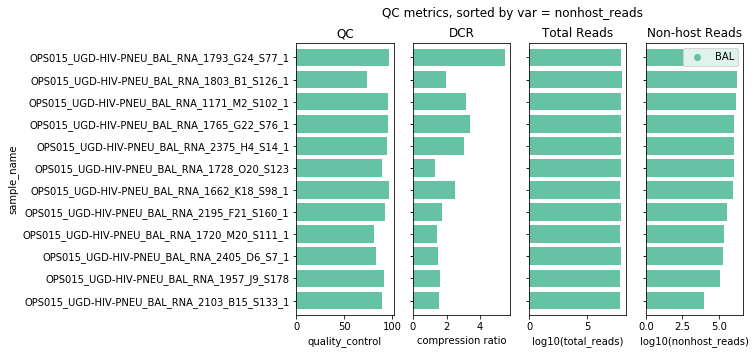

In [5]:
sort_var = 'nonhost_reads'
report_csv_df.sort_values(by=sort_var, inplace=True)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(8,FIG_LENGTH), sharey=True)

fig_colors = [color_dict[i] for i in report_csv_df[metadata_var]]

ax1.set_title('QC')
ax1.set_xlabel('quality_control')
report_csv_df['quality_control'].plot(kind='barh', width=.8, ax=ax1, color=fig_colors)

ax2.set_title('DCR')
ax2.set_xlabel('compression ratio')
report_csv_df['compression_ratio'].plot(kind='barh', width=.8, ax=ax2, color=fig_colors)

ax3.set_title('Total Reads')
ax3.set_xlabel('log10(total_reads)')
np.log10(report_csv_df['total_reads']).plot(kind='barh', width=.8, ax=ax3, color=fig_colors)

ax4.set_title('Non-host Reads')
ax4.set_xlabel('log10(nonhost_reads)')
np.log10(report_csv_df['nonhost_reads']).plot(kind='barh', width=.8, ax=ax4, color=fig_colors)


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
ax4.legend(markers, color_dict.keys(), numpoints=1)

for label in (ax1.get_yticklabels()):
    label.set_fontsize(SAMPLE_LABEL_FONT_SIZE)

fig.suptitle('QC metrics, sorted by var = ' + sort_var)
fig.savefig(output_dir + 'Figure1A.pdf', bbox_inches='tight')


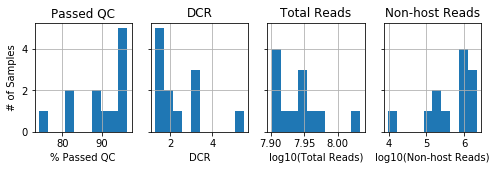

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(8,2), sharey=True)

report_csv_df['quality_control'].hist(bins=HIST_BINS, ax=ax1)
ax1.set_xlabel('% Passed QC')
ax1.set_ylabel('# of Samples')
ax1.set_title('Passed QC')

report_csv_df['compression_ratio'].hist(bins=HIST_BINS, ax=ax2)
ax2.set_xlabel('DCR')
ax2.set_title('DCR')

np.log10(report_csv_df['total_reads'] + 1).hist(bins=HIST_BINS, ax=ax3)
ax3.set_xlabel('log10(Total Reads)')
ax3.set_title('Total Reads')

np.log10(report_csv_df['nonhost_reads'] + 1).hist(bins=HIST_BINS, ax=ax4)
ax4.set_xlabel('log10(Non-host Reads)')
ax4.set_title('Non-host Reads')

fig.savefig(output_dir + 'Figure1B.pdf', bbox_inches='tight')


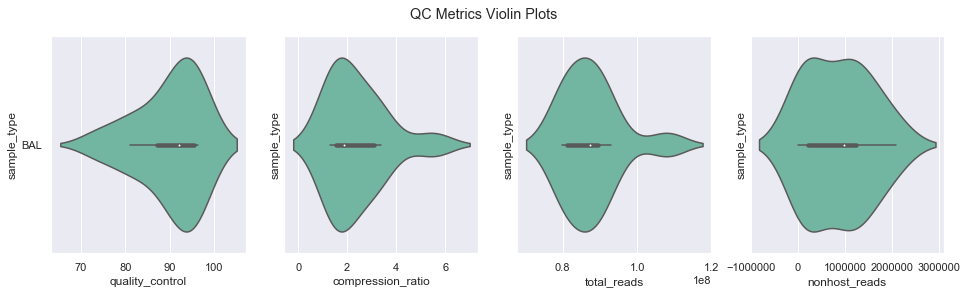

In [7]:
sns.set(font_scale=1)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,4), sharey=True)

sns.violinplot(y=metadata_var, x="quality_control", data=report_csv_df, scale="width", palette=color_dict, ax=ax1)
sns.violinplot(y=metadata_var, x="compression_ratio", data=report_csv_df, scale="width", palette=color_dict, ax=ax2)
sns.violinplot(y=metadata_var, x="total_reads", data=report_csv_df, scale="width", palette=color_dict, ax=ax3)
sns.violinplot(y=metadata_var, x="nonhost_reads", data=report_csv_df, scale="width", palette=color_dict, ax=ax4)

fig.suptitle("QC Metrics Violin Plots")
fig.savefig(output_dir + 'Figure1C.pdf', bbox_inches = 'tight')



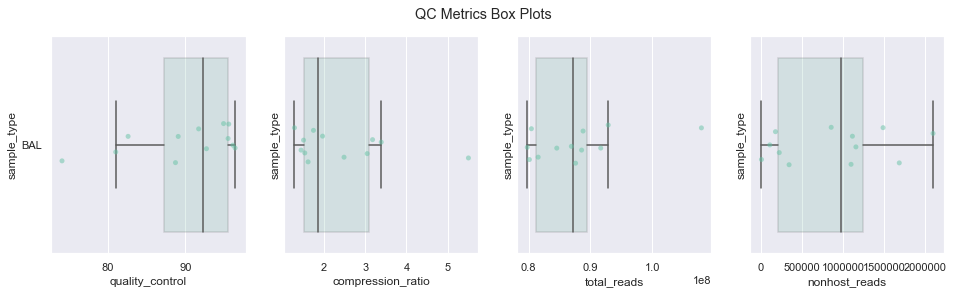

In [8]:
sns.set(font_scale=1)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,4), sharey=True)

sns.boxplot(y=metadata_var, x="quality_control", data=report_csv_df, color='white', ax=ax1, palette=color_dict,boxprops=dict(alpha=.2),showfliers=False)
sns.boxplot(y=metadata_var, x="compression_ratio", data=report_csv_df, color='white',  ax=ax2, palette=color_dict,boxprops=dict(alpha=.2),showfliers=False)
sns.boxplot(y=metadata_var, x="total_reads", data=report_csv_df,color='white',  ax=ax3, palette=color_dict,boxprops=dict(alpha=.2),showfliers=False)
sns.boxplot(y=metadata_var, x="nonhost_reads", data=report_csv_df, color='white', ax=ax4, palette=color_dict,boxprops=dict(alpha=.2),showfliers=False)


sns.stripplot(y=metadata_var, x="quality_control", data=report_csv_df, palette=color_dict, ax=ax1, alpha = .5)
sns.stripplot(y=metadata_var, x="compression_ratio", data=report_csv_df, palette=color_dict, ax=ax2, alpha = .5)
sns.stripplot(y=metadata_var, x="total_reads", data=report_csv_df, palette=color_dict, ax=ax3, alpha = .5)
sns.stripplot(y=metadata_var, x="nonhost_reads", data=report_csv_df, palette=color_dict, ax=ax4, alpha = .5)

fig.suptitle("QC Metrics Box Plots")
fig.savefig(output_dir + 'Figure1D.pdf', bbox_inches = 'tight')


### Reads Filtered at each Host Filtering Step

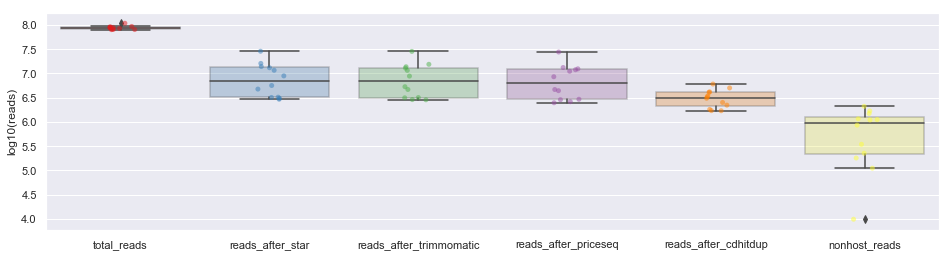

In [9]:
plt.figure(figsize = (16,4))
strip_df = np.log10(report_csv_df[['total_reads','reads_after_star', 'reads_after_trimmomatic', 'reads_after_priceseq','reads_after_cdhitdup','nonhost_reads']] + 1)
sns.stripplot(data=strip_df,palette="Set1", alpha=.5)
sns.boxplot(data=strip_df,palette="Set1",boxprops=dict(alpha=.3))
plt.ylabel('log10(reads)')
fig.savefig(output_dir + 'Figure2B.pdf', bbox_inches='tight')


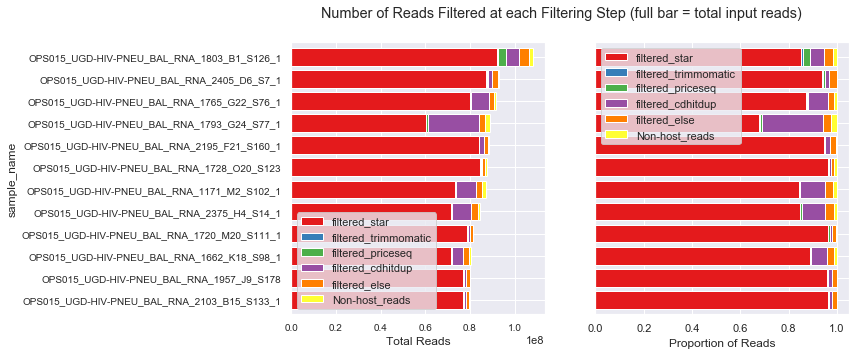

In [10]:
df = report_csv_df


df['Non-host_reads'] = df['nonhost_reads']
df['filtered_else'] = df['reads_after_cdhitdup'] - df['nonhost_reads']
df['filtered_cdhitdup'] = df['reads_after_priceseq'] - df['reads_after_cdhitdup']
df['filtered_priceseq'] = df['reads_after_trimmomatic'] - df['reads_after_priceseq']
df['filtered_trimmomatic'] = df['reads_after_star'] - df['reads_after_trimmomatic']
df['filtered_star'] = df['total_reads'] - df['reads_after_star']

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(10,FIG_LENGTH), sharey=True)

sorted_sample_ids = df[['Non-host_reads','filtered_else','filtered_cdhitdup','filtered_priceseq','filtered_trimmomatic','filtered_star']].sum(axis=1).sort_values().index
df[['filtered_star','filtered_trimmomatic','filtered_priceseq','filtered_cdhitdup','filtered_else','Non-host_reads']].loc[sorted_sample_ids].plot(kind='barh', stacked = True, width = .8, color=sns.color_palette("Set1"), ax=ax1)
ax1.set_xlabel("Total Reads")

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(SAMPLE_LABEL_FONT_SIZE)

normalized_df = (df[['filtered_star','filtered_trimmomatic','filtered_priceseq','filtered_cdhitdup','filtered_else','Non-host_reads']].div(df['total_reads'], axis=0))
normalized_df.loc[sorted_sample_ids].plot(kind='barh', stacked = True, width = .8, color=sns.color_palette("Set1"), ax=ax2)
ax2.set_xlabel("Proportion of Reads")

fig.suptitle("Number of Reads Filtered at each Filtering Step (full bar = total input reads)")
fig.savefig(output_dir + 'Figure2A.pdf', bbox_inches='tight')


### Create Host Gene Counts Matrix

In [11]:
if genecounts_dir:
    
    # Loop through the directory of STAR genecounts, generate a matrix of genes x samples
    genecounts = {}
    for i in glob.glob(genecounts_dir + '/*'):
        gc = pd.read_csv(i, index_col = 0, header=None, sep='\t')
        genecounts[i.split('/')[-1]]=gc[1]

    genecounts_df = pd.DataFrame(genecounts)
    genecounts_df.to_csv(output_dir + 'genecounts.csv')

    
    # Get ERCC Dataframe - subset of the gene counts matrix
    ercc_df = genecounts_df.loc[list(filter(lambda x:'ERCC' in x, genecounts_df.index))]
    fixed_columns = ['_'.join(i.split('_')[0:-1]) for i in ercc_df.columns]
    ercc_df.columns = fixed_columns


### Gene biotype abundance

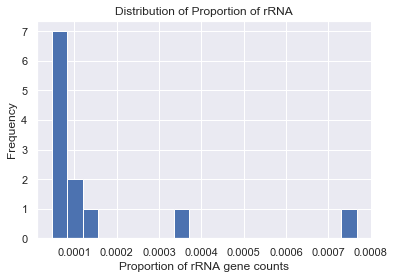

In [12]:
if genecounts_dir:

    # read in the gene biotype info to enable filtering for specific gene types (ie rRNA)
    gene_biotype_df = pd.read_csv(gene_biotype, index_col = 0)
    gc_df = genecounts_df.loc[list(filter(lambda x:'ENSG' in x, genecounts_df.index))]
    gc_df.index = [i.split('.')[0] for i in gc_df.index]

    merged = gene_biotype_df.join(gc_df) 
    merged.head()

    rRNA_indices = [i for i in range(len(merged['gene_biotype'])) if 'rRNA' in merged['gene_biotype'].iloc[i]]
    merged['gene_biotype'].iloc[rRNA_indices]

    rRNA_genecounts = merged.iloc[rRNA_indices] # counts associated with rRNA genes

    # compute the proportion of genecounts associated with rRNA genes
    # note: this is highly dependent on the .gtf file that was used for analysis
    rrna_proportion = {}
    rrna_counts = rRNA_genecounts[rRNA_genecounts.columns[2:len(rRNA_genecounts.columns)]].sum()
    total_counts = merged[merged.columns[2:len(merged.columns)]].sum()
    rrna_proportion = rrna_counts/total_counts

    rrna_proportion.fillna(0)
    rrna_proportion.plot(kind='hist', bins=20)
    plt.title("Distribution of Proportion of rRNA")
    plt.xlabel("Proportion of rRNA gene counts")

    plt.savefig(output_dir + 'Figure3.pdf', bbox_inches='tight')
    
    gene_biotype_df
    rRNA_indices = [i for i in range(len(merged['gene_biotype'])) if 'rRNA' in merged['gene_biotype'].iloc[i]]
    merged['gene_biotype'].iloc[rRNA_indices]


### Number of ERCCs detected per sample

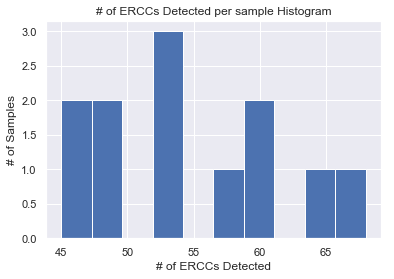

In [13]:
if genecounts_dir:
    
    # plot the number of ERCCs detected per sample
    (ercc_df > 0).sum().hist(bins=HIST_BINS)
    plt.xlabel('# of ERCCs Detected')
    plt.ylabel('# of Samples')
    plt.title('# of ERCCs Detected per sample Histogram')
    plt.savefig(output_dir + 'Figure4A.pdf', bbox_inches='tight')


### ERCC Concentration Analysis

In [14]:
if genecounts_dir:

    # read in the reference file associating ERCCs with concentration values
    ercc_ref = pd.read_csv(ercc_reference, sep='\t',index_col=1)
    ercc_ref_sorted = ercc_ref.loc[ercc_df.index]  # sort the ERCC reference to match count data rows

    #
    # Collect R-squared values
    #

    rsq_coefs = {}
    for i in ercc_df.columns:
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(ercc_df[i] + 1), 
                                                  np.log10(ercc_ref_sorted['concentration in Mix 1 (attomoles/ul)'] + 1))
        rsq_coefs[i] = r_value**2

    rsq_coefs_series = pd.Series(rsq_coefs)


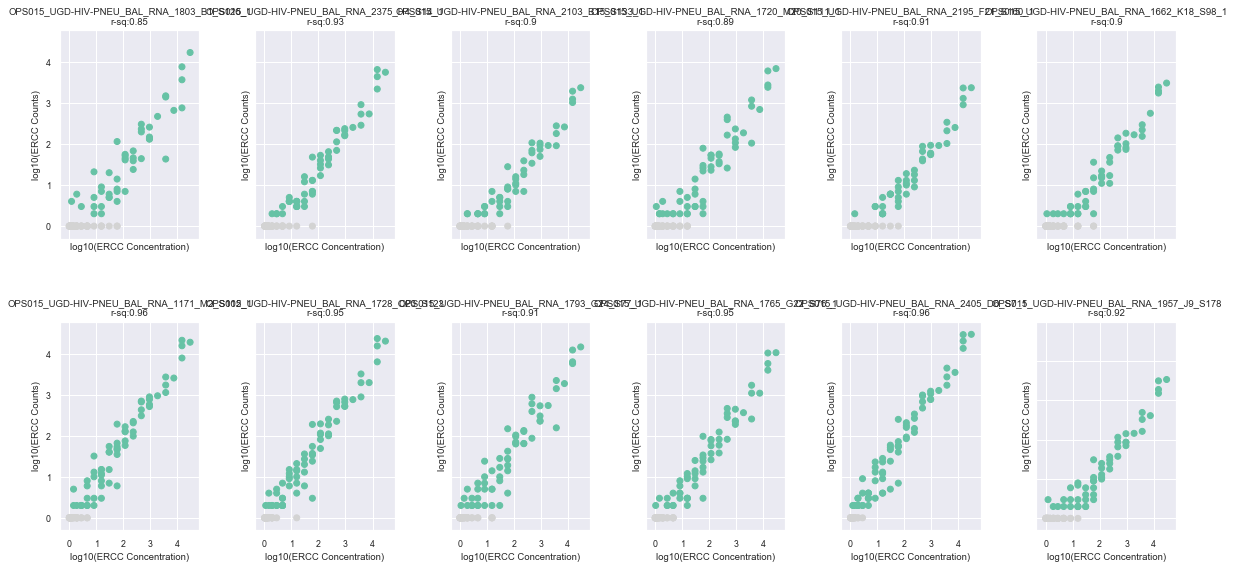

In [15]:
if genecounts_dir:

    #
    # Plot all ERCC scatterplots as separate plots on one page
    #       (should be same graph as shown in IDseq interface)
    #

    sns.set(font_scale=.8)

    total_samples = len(ercc_df.columns)
    ncol = 6
    nrow = int(np.ceil(total_samples / ncol))

    fig, axarr = plt.subplots(nrow,ncol, figsize=(20, 4.6*nrow), sharex=True, sharey=True, facecolor='white')
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    row = 0
    col = 0

    for i in ercc_df.columns:
        yvals = (np.log10(ercc_df[[i]] + 1))

        curr_color = color_dict[report_csv_df.loc[i][metadata_var]]

        axarr[row,col].scatter(np.log10(ercc_ref_sorted['concentration in Mix 1 (attomoles/ul)']+1) ,
                               yvals, color = [[curr_color,'lightgrey'][j == 0] for j in list(yvals[i])])                           
        axarr[row,col].set_xlabel('log10(ERCC Concentration)')
        axarr[row,col].set_ylabel('log10(ERCC Counts)')
        axarr[row,col].set_title(i + '\nr-sq:' + str(np.round(rsq_coefs[i],2)))
        axarr[row,col].set_xticks(np.arange(0,5,1))
        axarr[row,col].set_yticks(np.arange(0,6,1))


        if col == ncol-1:
            row += 1
            col = 0
        else:
            col += 1 


    plt.savefig(output_dir + 'Figure4B_ERCC_counts_plots.pdf')

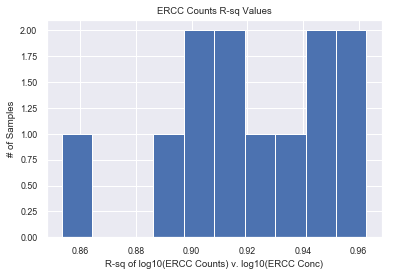

In [16]:
if genecounts_dir:

    #
    # Concentration v. Read Count Correlation
    #
    rsq_coefs_series.hist(bins=HIST_BINS)
    plt.xlabel('R-sq of log10(ERCC Counts) v. log10(ERCC Conc)')
    plt.ylabel('# of Samples')
    plt.title("ERCC Counts R-sq Values")
    #plt.xlim(0,1)
    plt.savefig(output_dir + 'Figure4C.pdf', bbox_inches='tight')
    

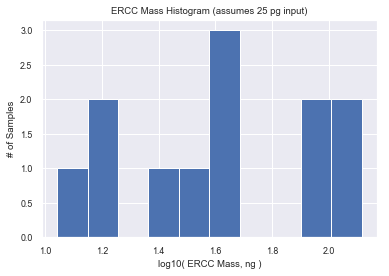

Series([], dtype: int64)


In [17]:
if genecounts_dir:
    
    # Calculate ERCC Mass
    #
    # ERCC mass (pg) / Total mass (pg) = ERCC reads / Total reads … 
    # this value will be calculated here using the standard input of 25pg
    #
    
    input_ercc_pg = 25

    # ERCC mass (pg) / Total mass (pg) = ERCC reads / Total Reads
    # 25 (pg) / Total mass (pg) = ERCC reads / Total Reads
    # 
    # Total mass (pg) = (Total Reads / ERCC reads) * 25 pg

    # IDseq counts each read in the pair as a single read, 
    #     therefore the ERCC counts need to be multiplied by two
    ercc_sum = ercc_df.sum() * 2  

    # only compute mass scale for samples with ERCC sum > 0
    
    # Total Mass (pg) = ( Total Reads / ERCC Reads ) * 25 pg
    ercc_mass_pg = ((report_csv_df.loc[ercc_sum.index]['total_reads'][ercc_sum!=0] / 
                     (ercc_sum)[ercc_sum!=0])) * input_ercc_pg    
    
    # Input Mass = Total Mass - Input ERCC Mass
    input_mass_pg = ercc_mass_pg - input_ercc_pg                  
    
    # Convert from pg to ng
    input_mass_ng = input_mass_pg / 1000

    np.log10(input_mass_ng + 1).hist(bins=HIST_BINS)
    plt.title('ERCC Mass Histogram (assumes 25 pg input)')
    plt.ylabel('# of Samples')
    plt.xlabel('log10( ERCC Mass, ng )')
    plt.savefig(output_dir + 'Figure4D.pdf', bbox_inches='tight')
    plt.show()

    # samples for which ERCC mass scale could not be computed:
    print(ercc_sum[ercc_sum == 0])

    input_mass_col = []
    for i in report_csv_df.index:
        try:
            input_mass_col.append(input_mass_ng.loc[i])
        except:
            input_mass_col.append(None)
    report_csv_df['input_mass'] = input_mass_col



In [18]:
if genecounts_dir:
    report_csv_df.merge(ercc_sum.rename('ercc_sum'), left_index=True, right_index=True)

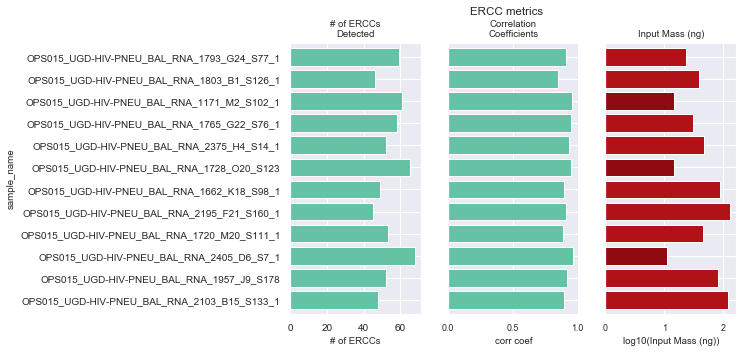

In [19]:
if genecounts_dir:

    #
    # Plot common ERCC metrics - 
    # *NOTE* that the "Input Mass" plot is colored using a color scale in which
    #   light red indicates lower "Correlation" between ERCC counts and input concentrations, 
    #   which may indicate reduced confidence in the input mass calculation.
    #
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(8,FIG_LENGTH), sharey=True)

    fig_colors = [color_dict[i] for i in report_csv_df[metadata_var]]
    
    ax1.set_title('# of ERCCs\nDetected')
    ax1.set_xlabel('# of ERCCs')
    (ercc_df > 0).sum().loc[report_csv_df.index].plot(kind='barh', width=.8, ax=ax1, color=fig_colors)

    for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
        label.set_fontsize(SAMPLE_LABEL_FONT_SIZE)

    ax2.set_title('Correlation\nCoefficients')
    ax2.set_xlabel('corr coef')
    pd.Series(rsq_coefs)[report_csv_df.index].plot(kind='barh', width=.8, ax=ax2, color=fig_colors)

    ax3.set_title('Input Mass (ng)')
    ax3.set_xlabel('log10(Input Mass (ng))')
    cd = sns.color_palette("Reds", 11)
    col_index = [i if not math.isnan(i) else 0 for i in np.round(rsq_coefs_series.loc[report_csv_df.index]*10)]
    np.log10(report_csv_df['input_mass'] + 1).plot(kind='barh', width=.8, ax=ax3, color=[cd[int(i)] for i in col_index])

    fig.suptitle('ERCC metrics')
    fig.savefig(output_dir + 'Figure4E.pdf', bbox_inches='tight')


### Create Microbe Matrix - [this is the taxmat input for phyloseq]

The result is a full, merged, tab-delimited matrix of *raw values* for each sample in the project. The raw values of interest were specified in the input at the top of the notebook (variables `var_of_interest` and `tax_level`)

This is comparable to downloading the heatmap for external use, except includes ALL the data.


In [20]:
report_files = glob.glob(report_dir + "/*.csv")
series_list = []
series_names = []
this_species = {}

no_results_found = []

for rf in report_files:

    try:
        rf_df = pd.read_csv(rf)
    except:
        no_results_found.append(rf)
        continue
        
    if tax_level == 'species':
        rf_df = rf_df[rf_df.tax_level == 1]    
    elif tax_level == 'genus':
        rf_df = rf_df[rf_df.tax_level == 2]
        
    rf_df = rf_df[rf_df.NT_alignmentlength > NT_L_filter]
    rf_df = rf_df[rf_df.NR_alignmentlength > NR_L_filter]
        
    assert(rf_df.shape[0] == len(set(list(rf_df['tax_id']))))
    
    new_idx = [str(rf_df.iloc[i]['category_name']) + '_' + 
                   str(rf_df.iloc[i]['family_taxid']) + '_' + 
                   str(rf_df.iloc[i]['genus_taxid']) + '_' + 
                   str(rf_df.iloc[i]['tax_id']) + '_' + 
                   rf_df.iloc[i]['name'] for i in range(len(rf_df.index))]
    rf_df.index = new_idx
    rf_df = rf_df[var_of_interest]
        
    series_names.append(rf.split('/')[-1].split('.')[0])
    series_list.append(rf_df)
    
result = pd.concat(series_list, axis=1, join='outer')
result.columns = series_names
result.fillna(0, inplace=True)

for rf_nores in no_results_found:
    result[rf_nores.split('/')[-1].split('.')[0]] = 0 

result.index.name = '#NAME'
result.to_csv(output_dir + 'microbe_report.' + var_of_interest + '_' + tax_level  + '.tsv', sep='\t')
result.transpose().head(10) # show the microbe matrix


#NAME,Archaea_-300_1825023_1603555_Candidatus Nitrosotenuis cloacae,Archaea_2159_2172_2173_Methanobrevibacter smithii,Archaea_2159_2172_66851_Methanobrevibacter oralis,Bacteria_-300_-200_1256569_uncultured bacterium A1Q1_fos_25,Bacteria_-300_-200_1394709_candidate division SR1 bacterium RAAC1_SR1_1,Bacteria_-300_-200_1476577_Candidatus Saccharibacteria oral taxon TM7x,Bacteria_-300_-200_1690483_Bacteroidetes bacterium UKL13-3,Bacteria_-300_-200_1701327_uncultured bacterium 5H7,Bacteria_-300_-200_172733_uncultured Clostridiales bacterium,Bacteria_-300_-200_1848255_Actinobacteria bacterium IMCC25003,...,Viruses_687329_687331_687344_Torque teno virus 5,Viruses_687329_687331_687346_Torque teno virus 7,Viruses_687329_687331_687347_Torque teno virus 8,Viruses_687329_687331_687349_Torque teno virus 10,Viruses_687329_687331_687350_Torque teno virus 11,Viruses_687329_687331_687352_Torque teno virus 13,Viruses_687329_687331_687355_Torque teno virus 16,Viruses_687329_687331_687358_Torque teno virus 19,Viruses_687329_687331_687359_Torque teno virus 20,Viruses_687329_687333_2065051_Torque teno midi virus 10
OPS015_UGD-HIV-PNEU_BAL_RNA_2375_H4_S14_1,0.000,0.000,0.000,0.00000,0.000,0.0,0.00,0.000,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.000
OPS015_UGD-HIV-PNEU_BAL_RNA_1171_M2_S102_1,0.000,0.000,0.000,0.00000,0.000,0.0,0.00,0.000,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.000
OPS015_UGD-HIV-PNEU_BAL_RNA_1662_K18_S98_1,0.000,0.000,0.000,0.00000,0.000,0.0,0.00,0.000,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.000
OPS015_UGD-HIV-PNEU_BAL_RNA_1765_G22_S76_1,0.000,0.000,0.000,0.00000,0.000,0.0,0.00,0.021,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.000
OPS015_UGD-HIV-PNEU_BAL_RNA_2103_B15_S133_1,0.000,0.000,0.000,0.00000,0.000,0.0,0.00,0.000,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.000
OPS015_UGD-HIV-PNEU_BAL_RNA_1803_B1_S126_1,0.064,0.000,0.000,0.00900,0.000,0.0,0.24,0.000,0.000,0.055,...,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.000
OPS015_UGD-HIV-PNEU_BAL_RNA_2405_D6_S7_1,0.000,0.000,0.000,0.00000,0.313,0.0,0.00,0.000,0.021,0.000,...,0.075,0.107,0.01,0.075,0.043,0.021,0.01,0.000,0.021,0.000
OPS015_UGD-HIV-PNEU_BAL_RNA_2195_F21_S160_1,0.000,0.000,0.000,0.00000,0.000,0.0,0.00,0.000,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.022,0.000,0.000
OPS015_UGD-HIV-PNEU_BAL_RNA_1728_O20_S123,0.000,0.446,0.491,0.00000,0.000,0.0,0.00,0.000,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.011,0.00,0.000,0.000,0.022
OPS015_UGD-HIV-PNEU_BAL_RNA_1793_G24_S77_1,0.000,0.000,0.000,0.02503,0.000,0.0,0.00,0.000,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.000


In [21]:
# phyloseq specifically requires taxonomic IDs in the index values (not including name info) 

result_phyloseq = result.copy(deep=True)
result_phyloseq.index = [i.split('_')[3] for i in result_phyloseq.index]
result_phyloseq.to_csv(output_dir + 'phyloseq_microbe_report.' + var_of_interest + '_' + tax_level  + '.tsv', sep='\t')


### Plot the proportion of reads in each category {Bacteria, Viruses, Eukaryotes, Uncategorized}

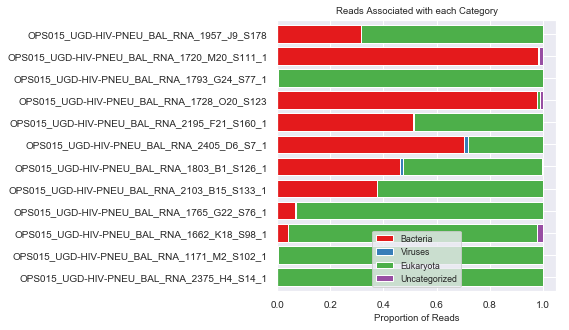

In [22]:
bacteria_index = [i for i in range(len(result.index)) if 'Bacteria' in result.index[i] ]
virus_index = [i for i in range(len(result.index)) if 'Virus' in result.index[i] ]
eukaryota_index = [i for i in range(len(result.index)) if 'Eukaryota' in result.index[i] ]
uncategorized_index = [i for i in range(len(result.index)) if 'Uncategorized' in result.index[i] ]

bact_sum = result.iloc[bacteria_index].sum()
vir_sum = result.iloc[virus_index].sum()
euk_sum = result.iloc[eukaryota_index].sum()
uncategorized_sum = result.iloc[uncategorized_index].sum()
total_sum = result.sum()

category_df = pd.concat([bact_sum, vir_sum, euk_sum, uncategorized_sum],axis=1)
category_df.columns = ['Bacteria','Viruses','Eukaryota','Uncategorized']

fig, (ax1) = plt.subplots(1, 1,  figsize=(5,FIG_LENGTH), sharey=True)

normalized_category_df = category_df.div(category_df.sum(axis=1), axis=0)
normalized_category_df.plot(kind='barh', stacked = True, width = .8, color=sns.color_palette("Set1"), ax = ax1)
ax1.set_xlabel("Proportion of Reads")
ax1.set_title("Reads Associated with each Category")

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(SAMPLE_LABEL_FONT_SIZE)

fig.savefig(output_dir + 'Figure5A.pdf', bbox_inches='tight')


### Plot Relative Abundance for a Particular Genus of Interest

The function `plot_single_genus()` can be run with any genus taxid you are interested in.
In the cell below, there is an example for plotting all species in the genus Escherichia. 


To evaluate your genus of interest, identify the genus taxid (this can be done by selecting the taxon name in the IDseq report and clicking the NCBI link), and then run the function as follows:

`plot_single_genus(result, \[your genus NCBI taxid\])`

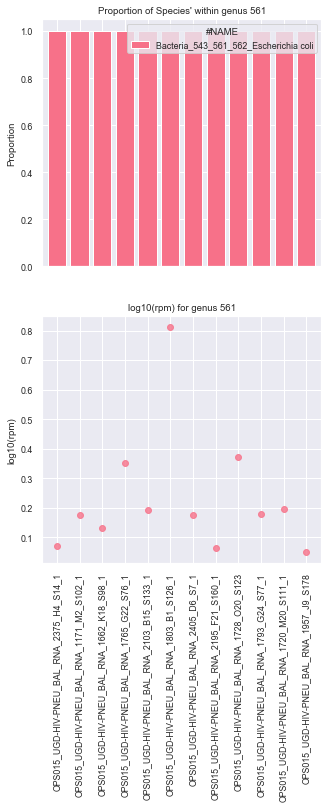

In [23]:
def plot_single_genus(result_matrix, genus_taxid):
    relevant_indices = [i for i in range(len(result_matrix.index)) if '_' + str(genus_taxid) + '_' in result_matrix.index[i] ]
    
    plotting_data = result_matrix.iloc[relevant_indices].transpose()    
    plotting_data_normalized = plotting_data.div(plotting_data.sum(axis=1), axis=0)

    colors = sns.color_palette("husl", len(plotting_data.columns))
    
    fig, (ax1, ax2) = plt.subplots(2, 1,  figsize=(FIG_LENGTH,10), sharex=True)
    
    plotting_data_normalized.plot(kind='bar',stacked=True, ax=ax1, color=colors, width=.8)
    ax1.set_title("Proportion of Species' within genus " + str(genus_taxid))
    ax1.set_ylabel('Proportion')
    
    for i in range(len(plotting_data.columns)):
        ax2.plot([j for j in range(len(plotting_data.index))], 
                 np.log10(plotting_data[plotting_data.columns[i]] + 1), linestyle="",marker="o", 
                 color=colors[i], alpha=.8)
        
    ax2.set_title('log10(rpm) for genus ' + str(genus_taxid))
    ax2.set_ylabel('log10(rpm)')
    ax2.set_xticklabels(plotting_data.index, rotation='vertical')
    
    fig.savefig(output_dir + 'Figure7_genus' + str(genus_taxid) + '.pdf', bbox_inches='tight')

    
plot_single_genus(result, 561) #example, plot all species in genus Escherichia (NCBI Taxonomy taxid = 561)

## Microbiome metrics

could not compute metric: ace
could not compute metric: faith_pd
could not compute metric: lladser_ci
could not compute metric: lladser_pe
could not compute metric: michaelis_menten_fit


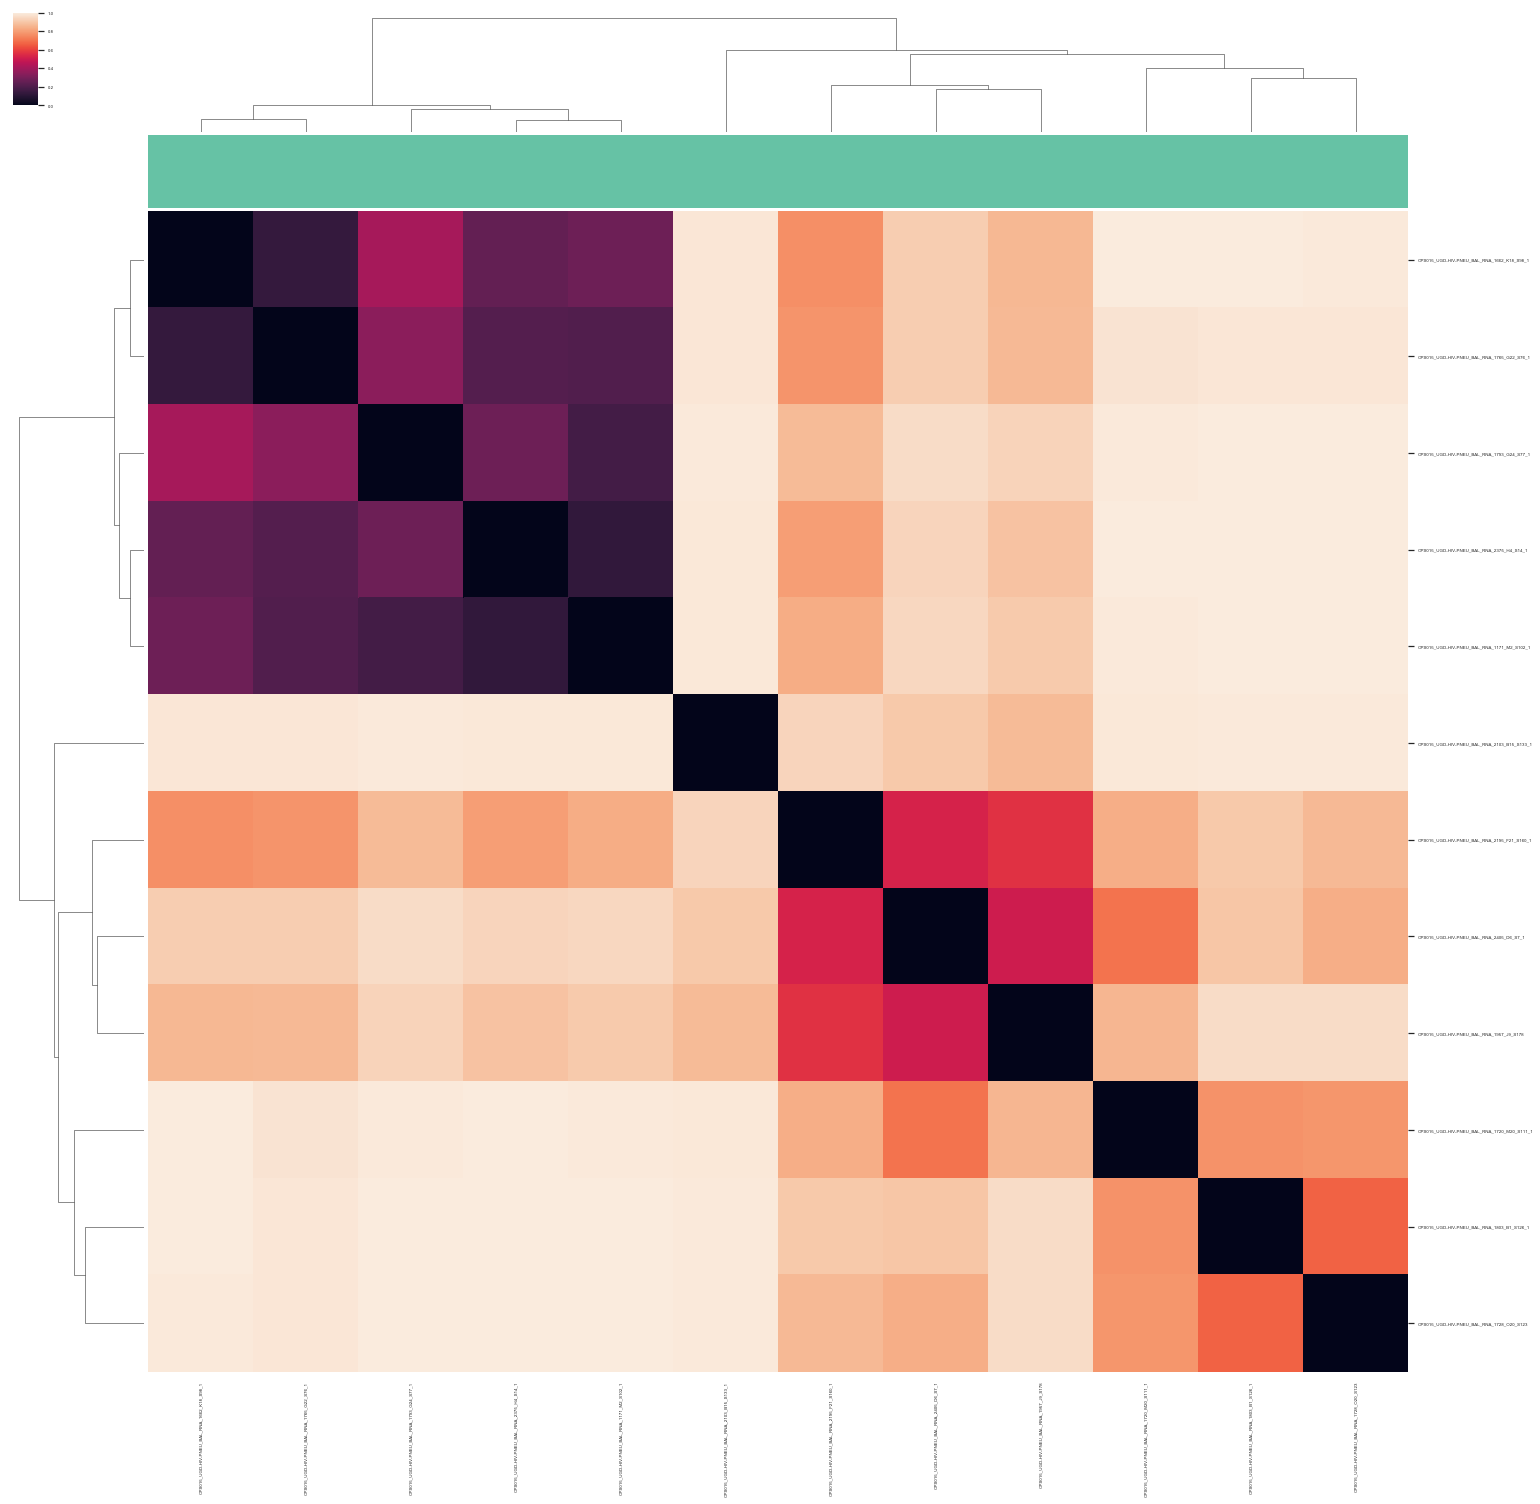

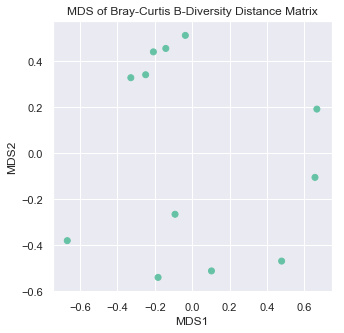

In [24]:
possible_diversity_metrics = skbio.diversity.get_alpha_diversity_metrics()

metrics = []
computed_metrics = []
for i in possible_diversity_metrics:
    try:
        metrics.append(skbio.diversity.alpha_diversity(i, result.transpose().values.tolist(), list(result.columns)))
        computed_metrics.append(i)
    except:
        print("could not compute metric: " + i)
        
metrics_df = pd.concat(metrics, axis=1)
metrics_df.columns = computed_metrics

metrics_df.to_csv(output_dir + 'microbiome_alphareport.csv')


result_filtered = result[result.columns[result.sum() > 0]]

bc_dm = beta_diversity("braycurtis", result_filtered.transpose().values.tolist(), list(result_filtered.columns))

bc_df = pd.DataFrame(bc_dm.data, columns = bc_dm.ids, index = bc_dm.ids)
bc_df.to_csv(output_dir + 'bray_curtis_diversityreport.csv')

sns.set(font_scale=0.4)
sns.clustermap(bc_df, figsize=(25,25), 
               col_colors = [color_dict[i] for i in report_csv_df.loc[bc_df.columns][metadata_var]])
plt.savefig(output_dir + 'Figure8A.pdf')


mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(bc_df)
coords = results.embedding_

sns.set(font_scale=1)
fig = plt.figure(figsize=(5,5))
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o', color = [color_dict[report_csv_df[metadata_var].loc[i]] for i in bc_df.columns]
    )
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS of Bray-Curtis B-Diversity Distance Matrix')
plt.savefig(output_dir + 'Figure8B.pdf')



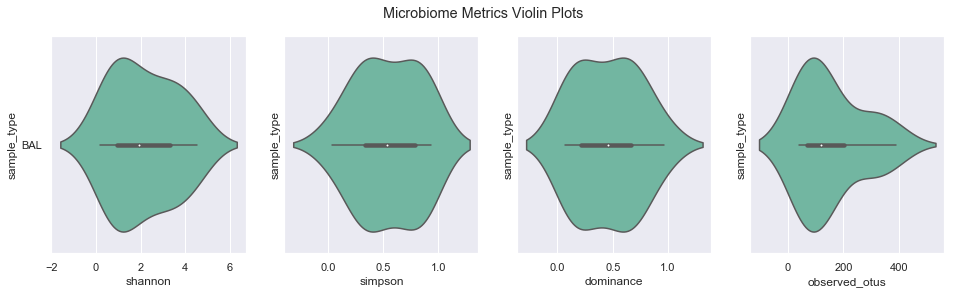

In [25]:
metrics_df[metadata_var] = report_csv_df.loc[metrics_df.index][metadata_var]

sns.set(font_scale=1)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,4), sharey=True)

sns.violinplot(y=metadata_var, x="shannon", data=metrics_df, scale="width", palette=color_dict, ax=ax1)
sns.violinplot(y=metadata_var, x="simpson", data=metrics_df, scale="width", palette=color_dict, ax=ax2)
sns.violinplot(y=metadata_var, x="dominance", data=metrics_df, scale="width", palette=color_dict, ax=ax3)
sns.violinplot(y=metadata_var, x="observed_otus", data=metrics_df, scale="width", palette=color_dict, ax=ax4)

fig.suptitle("Microbiome Metrics Violin Plots")
fig.savefig(output_dir + 'Figure8C.pdf', bbox_inches = 'tight')


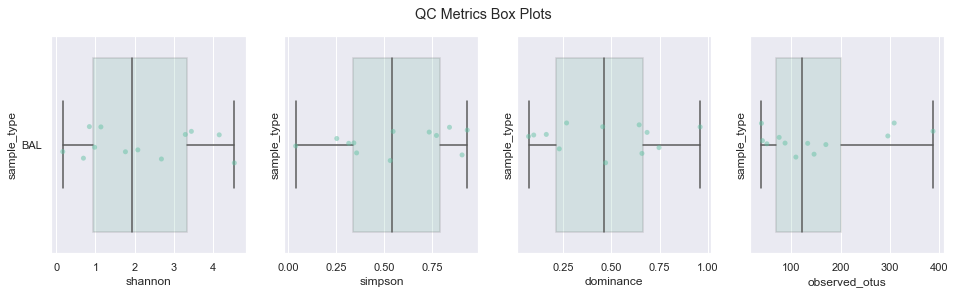

In [26]:
sns.set(font_scale=1)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,4), sharey=True)

sns.boxplot(y=metadata_var, x="shannon", data=metrics_df, palette=color_dict,boxprops=dict(alpha=.2), ax=ax1)
sns.boxplot(y=metadata_var, x="simpson", data=metrics_df,  palette=color_dict,boxprops=dict(alpha=.2), ax=ax2)
sns.boxplot(y=metadata_var, x="dominance", data=metrics_df, palette=color_dict,boxprops=dict(alpha=.2), ax=ax3)
sns.boxplot(y=metadata_var, x="observed_otus", data=metrics_df,  palette=color_dict,boxprops=dict(alpha=.2), ax=ax4)

sns.stripplot(y=metadata_var, x="shannon", data=metrics_df, palette=color_dict, ax=ax1, alpha = .5)
sns.stripplot(y=metadata_var, x="simpson", data=metrics_df, palette=color_dict, ax=ax2, alpha = .5)
sns.stripplot(y=metadata_var, x="dominance", data=metrics_df, palette=color_dict, ax=ax3, alpha = .5)
sns.stripplot(y=metadata_var, x="observed_otus", data=metrics_df, palette=color_dict, ax=ax4, alpha = .5)

fig.suptitle("QC Metrics Box Plots")
fig.savefig(output_dir + 'Figure8D.pdf', bbox_inches = 'tight')


## Downstream File Downloads (for use with phyloseq package in R)

### Tree format for phyloSeq

In [27]:
ncbi = NCBITaxa()

lin = {}
no_lin = {}
for i in list(result.index):
    curr_i = i.split('_')[3]
    try:
        lin[curr_i] = ncbi.get_lineage(curr_i)  # these are not all the same length...causes problems
    except:
        print(i)
        no_lin[curr_i] = i.split('_')[4]

In [28]:
lin_full = {}
no_lin_full = {}
lk = list(lin.keys())
nlk = list(no_lin.keys())

for j in lk:
    taxa = lin[j]
    translated = ncbi.get_taxid_translator(lin[j])
    ranks = ncbi.get_rank(lin[j])

    d_humanreadable = dict(zip(ranks.values(), translated.values()))
    d_taxons = dict(zip(ranks.values(), taxa))
    
    lin_full[j] = d_humanreadable
    
    
full_taxa_df = pd.DataFrame(lin_full)
final_df = full_taxa_df.transpose()[["superkingdom","phylum","class","order","family","genus","species"]]
final_df.columns = ["kingdom","phylum","class","order","family","genus","species"]
final_df.index.name = '#TAXONOMY'


for i in no_lin.keys():
    ser = pd.Series({'species':no_lin[i]})
    ser.rename(i, inplace=True)
    final_df = final_df.append(ser)
    
final_df.to_csv(output_dir + 'taxa_file.tsv', sep='\t') 
final_df.head(10)


,kingdom,phylum,class,order,family,genus,species
#TAXONOMY,,,,,,,
1603555,Archaea,Thaumarchaeota,NaN,NaN,NaN,Candidatus Nitrosotenuis,Candidatus Nitrosotenuis cloacae
2173,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter smithii
66851,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter oralis
1256569,Bacteria,NaN,NaN,NaN,NaN,NaN,uncultured bacterium A1Q1_fos_25
1394709,Bacteria,NaN,NaN,NaN,NaN,NaN,candidate division SR1 bacterium RAAC1_SR1_1
1476577,Bacteria,Candidatus Saccharibacteria,NaN,NaN,NaN,NaN,Candidatus Saccharibacteria oral taxon TM7x
1690483,Bacteria,Bacteroidetes,NaN,NaN,NaN,NaN,Bacteroidetes bacterium UKL13-3
1701327,Bacteria,NaN,NaN,NaN,NaN,NaN,uncultured bacterium 5H7
172733,Bacteria,Firmicutes,Clostridia,Clostridiales,NaN,NaN,uncultured Clostridiales bacterium


In [29]:
tree = ncbi.get_topology(list(lin_full.keys()))
tree.write(outfile = output_dir + "tree_file.newick")